In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

import geopandas as gpd

In [2]:
from kmodes.kmodes import KModes

In [3]:
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
dldc = pd.read_csv('../../cc_election_cleaning/district_level_demo_clusters.csv')

In [121]:
dldc.sort_values(by='demo_cluster')

,district,candidate,demo_cluster
33,34,Jennifer Gutierrez,0
35,36,Chi A. Osse,0
36,37,Sandy Nurse,0
6,7,Shaun Abreu,0
7,8,Diana I. Ayala,0
8,9,Kristin Richardson Jordan,0
9,10,Carmen N. De La Rosa,0
10,11,Eric Dinowitz,0
17,18,Amanda Farias,0
16,17,Rafael Salamanca Jr.,0


In [5]:
full_results_winner = full_results[full_results['winner'] == True]

In [5]:
full_results_winner.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       'kmode_cluster', 'member', 'ElectDist_x', 'ML4', 'ML6', 'ML5', 'ML2',
       'ML7', 'ML3', 'ML1', 'district_cluster', 'ElectDist_y', 'Shape_Leng',
       'Shape_Area', 'geometry', 'min_noise', 'max_noise',
       'summer_noise_complaints', 'min_arrests', 'max_arrests', 'density',
       'ldensity', 'p21own', 'p21rent', 'mhhi21', 'mean_noise', 'mean_arrests',
       'living_alone_ratio', 'same_sex_ratio', 'black_nys_ratio',
       'black_fb_ratio', 'white_transplant_ratio', 'femHHH_ratio',
       'drive_ratio', 'train_ratio', 'walk_ratio', 'bike_ratio', 'wfh_ratio',
       'bus_ratio', 'hh21olongp', 'h21p', 'nha21p', 'nhb21p', 'nhw21p',
       'mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p',
       'venez21p', 'hh21op', 'hh21rc', 'range_of_arrests', 'range_of_noise',
       'cvap21bapp', 'rv21irp', 'rv21italp', 'pg20jrbp'

In [6]:
key_demo_cols = [ 'district', 'cvap21bapp', 'mhhi21','h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio']
full__results_key_demo = full_results_winner[key_demo_cols]
ag = full__results_key_demo.groupby('district').agg('mean').reset_index()

In [7]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio']

In [8]:
for col in demographic_cols:
    ag[col + '_quintile'] = pd.qcut(ag[col], 5, labels=False) + 1

In [9]:
ag[ag['district'] == 22]

,district,cvap21bapp,mhhi21,h21p,nha21p,nhb21p,nhw21p,winda21p,white_transplant_ratio,cvap21bapp_quintile,mhhi21_quintile,h21p_quintile,nha21p_quintile,nhb21p_quintile,nhw21p_quintile,winda21p_quintile,white_transplant_ratio_quintile
21,22,49.746467,39873.545388,25.925276,14.958679,3.60946,51.19132,0.337785,11.642818,4,4,3,4,1,4,1,4


Look at citywide structure of occupation and race

In [10]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')

In [7]:
top_std_cols = occ_df[wp_cols].std().nlargest(11).index.tolist()

In [ ]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p','winda21p', 'white_transplant_ratio','hh21op','bus_ratio','drive_ratio','mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p']
demographic_cols.extend(top_std_cols)

In [150]:
demo_occ = pd.merge(full_results_winner, occ_df, left_on='ed_name', right_on='ElectDist')

In [153]:
demo_occ.shape

(6247, 281)

In [17]:
df_cluster = demo_occ[demographic_cols]

In [ ]:
df_cluster = demo_occ[demographic_cols]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

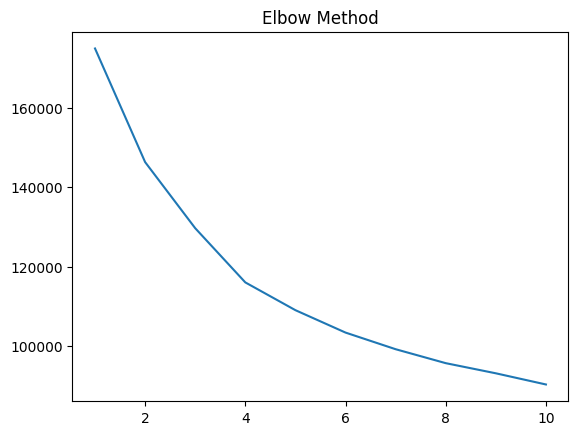

In [20]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [26]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(df_cluster_scaled)
df_cluster['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\samtg\AppData\Local\Temp\ipykernel_4028\394701120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = kmeans.labels_


In [28]:
averages = df_cluster.groupby('cluster')[demographic_cols].mean().round(2)

In [29]:
race_cols = ['nha21p', 'nhb21p', 'nhw21p','h21p']
averages['top_race'] = averages[race_cols].idxmax(axis=1)

In [36]:
averages[['top_race','mhhi21', 'white_transplant_ratio'] + top_std_cols].sort_values(by='mhhi21')

,top_race,mhhi21,white_transplant_ratio,w2psp,w2hsp,w2oadp,w2conp,w2foodp,w2salep,w2govp,w2bgp,w2mgtp,w2npp,w2pservep
cluster,,,,,,,,,,,,,,
5,h21p,13264.59,2.15,67.72,23.30,22.20,8.00,15.23,16.90,13.57,15.20,6.13,11.07,9.20
2,nhw21p,25029.82,9.34,59.30,9.22,21.86,5.75,8.99,15.38,12.46,6.11,11.60,15.35,6.18
6,nha21p,29982.86,2.10,69.64,19.78,21.84,12.78,16.46,19.37,10.16,7.68,7.43,8.40,10.87
3,nhb21p,33451.12,1.19,59.82,20.35,24.11,8.39,6.63,13.06,22.84,7.85,6.68,10.18,6.59
0,h21p,33855.47,2.86,69.69,13.64,23.59,22.00,21.80,21.23,9.97,15.29,6.63,7.73,8.81
1,nha21p,38279.44,1.97,62.69,7.22,22.04,7.46,7.21,22.64,14.40,4.51,11.80,9.02,7.72
4,nhw21p,42085.97,25.93,65.46,2.24,12.34,1.77,4.16,18.51,7.72,1.90,19.92,12.83,4.53
7,nhw21p,43920.97,2.58,60.28,11.07,24.81,10.07,7.16,18.18,18.39,6.16,9.82,9.13,5.86


In [37]:
df_cluster.shape

(6247, 29)

Try EFA

In [98]:
demographic_cols = ['cvap21bapp', 'mhhi21', 'h21p', 'nha21p', 'nhb21p', 'nhw21p', 'white_transplant_ratio','hh21op','bus_ratio','drive_ratio','mean_noise']
demographic_cols.extend(top_std_cols)

In [114]:
demo_occ.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       ...
       'wf2cop', 'w2psp', 'w2sep', 'w2npp', 'w2govp', 'w2nip', 'kdh24p',
       'djt24p', 'wfp24p', 'con24p'],
      dtype='object', length=281)

In [99]:
df_cluster = demo_occ[demographic_cols]
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

In [100]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_cluster_scaled)

FactorAnalyzer(rotation=None, rotation_kwargs={})

In [101]:
eigenvalues, _ = fa.get_eigenvalues()
print("Eigenvalues:", eigenvalues)

Eigenvalues: [5.73203569 3.07148367 2.39110417 1.07020701 1.0552879  0.96029652
 0.8929574  0.84253349 0.81033837 0.75153116 0.67247176 0.64920021
 0.5397435  0.51134517 0.47279921 0.41268472 0.38477947 0.25745352
 0.24225478 0.15693139 0.10900874 0.01355214]


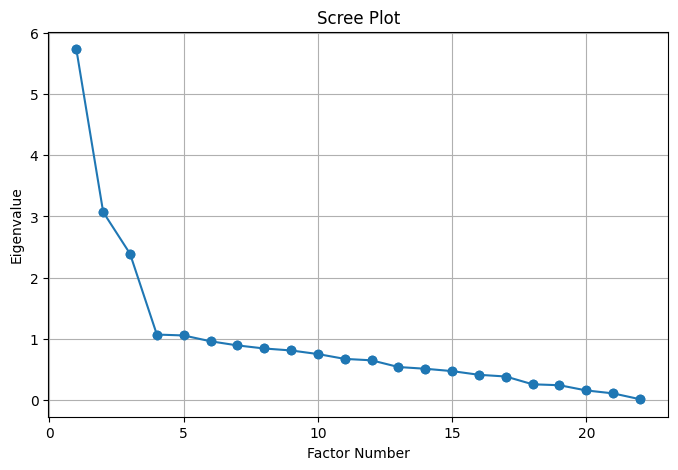

In [102]:
plt.figure(figsize=(8, 5))
plt.scatter(range(1, len(eigenvalues) + 1), eigenvalues)
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [103]:
num_factors = 4
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(df_cluster_scaled)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [104]:
df_cluster_scaled_factors = fa.transform(df_cluster_scaled)

In [105]:
df_cluster_scaled_factors = pd.DataFrame(df_cluster_scaled_factors, columns=[f'factor_{i}' for i in range(num_factors)])

In [106]:
df_cluster_scaled_factors['ed_name'] = demo_occ['ed_name']

In [107]:
df_cluster_scaled_factors['top_factor'] = df_cluster_scaled_factors[[f'factor_{i}' for i in range(num_factors)]].idxmax(axis=1)

In [108]:
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=df_cluster.columns, 
                           columns=[f'Factor{i+1}' for i in range(num_factors)])
print("Factor Loadings:\n", loadings_df)

Factor Loadings:
                          Factor1   Factor2   Factor3   Factor4
cvap21bapp             -0.897136  0.265259 -0.044218  0.096595
mhhi21                 -0.130849  0.384571  0.058620  0.051149
h21p                    0.426628 -0.697213  0.097864  0.232432
nha21p                  0.020515  0.327904  0.473374  0.187147
nhb21p                  0.351936 -0.079965 -0.331190 -0.875794
nhw21p                 -0.649668  0.383236 -0.134356  0.364610
white_transplant_ratio -0.918936 -0.068504 -0.049997  0.015372
hh21op                  0.090716  0.852552 -0.075619  0.166109
bus_ratio               0.556142 -0.081727 -0.071534 -0.148856
drive_ratio             0.531346  0.677270 -0.081885  0.152064
mean_noise              0.026852 -0.321364 -0.043873  0.000101
w2psp                  -0.010969 -0.207822  0.655385 -0.095922
w2hsp                   0.577766 -0.297391  0.098917 -0.243934
w2oadp                  0.396414  0.111756  0.070389 -0.015364
w2conp                  0.410611  0.0

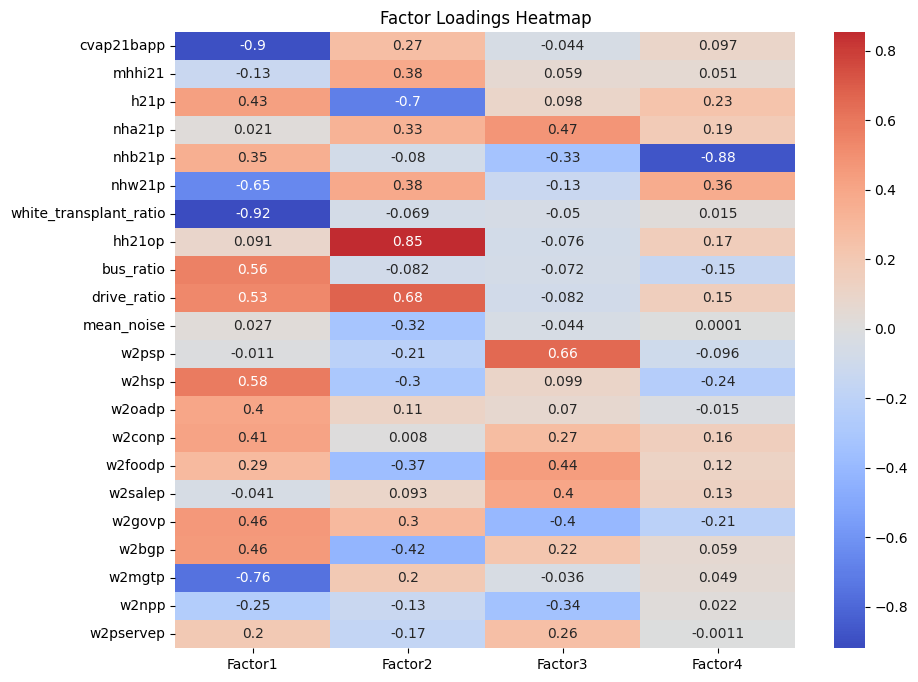

In [109]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("Factor Loadings Heatmap")
plt.show()

In [111]:
communalities = fa.get_communalities()
communalities_df = pd.DataFrame(communalities, index=df_cluster.columns, columns=['Communalities'])
print("Communalities:\n", communalities_df)

Communalities:
                         Communalities
cvap21bapp                   0.886500
mhhi21                       0.171069
h21p                         0.731719
nha21p                       0.367048
nhb21p                       1.006955
nhw21p                       0.719929
white_transplant_ratio       0.851871
hh21op                       0.768385
bus_ratio                    0.343249
drive_ratio                  0.770852
mean_noise                   0.105921
w2psp                        0.482040
w2hsp                        0.491544
w2oadp                       0.174824
w2conp                       0.268613
w2foodp                      0.427001
w2salep                      0.184930
w2govp                       0.506854
w2bgp                        0.437011
w2mgtp                       0.617142
w2npp                        0.197193
w2pservep                    0.134768


In [116]:
test = df_cluster_scaled_factors.merge(demo_occ[['ed_name','djt24p']], on='ed_name')

In [117]:
target = 'djt24p'
mod = sm.OLS(test[target], sm.add_constant(test[[f'factor_{i}' for i in range(num_factors)]]))
res = mod.fit()

Look at citywide breakdown of job, education, income 

In [130]:
top_mean_cols

['w2psp',
 'w2oadp',
 'w2salep',
 'w2govp',
 'w2hsp',
 'w2npp',
 'w2mgtp',
 'w2foodp',
 'w2conp',
 'w2bgp',
 'w2pservep',
 'w2edup',
 'w2banp',
 'w2nip',
 'w2tranp',
 'w2admp',
 'w2ffp',
 'w2docp',
 'w2sep',
 'w2cmp']

In [ ]:
['w2mgtp','w2banbp','w2cmp','w2aep','w2scip','w2cossp','w2lawp','w2edup','w2admp','w2docp',]

In [131]:
wp_cols

['w2mgtp',
 'w2banp',
 'w2cmp',
 'w2aep',
 'w2scip',
 'w2cossp',
 'w2lawp',
 'w2edup',
 'w2admp',
 'w2docp',
 'w2htp',
 'w2hsp',
 'w2ffp',
 'w2copp',
 'w2foodp',
 'w2bgp',
 'w2pservep',
 'w2salep',
 'w2oadp',
 'w2farmp',
 'w2conp',
 'w2emrp',
 'w2prodp',
 'w2tranp',
 'w2matp',
 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']

In [132]:
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [133]:
top_mean_cols = occ_df[wp_cols].mean().nlargest(20).index.tolist()

In [ ]:
demo_occ[wp_cols]

w2oadp       21.356286
w2salep      17.305053
w2hsp        13.378735
w2mgtp       10.345876
w2foodp      10.066707
w2conp        8.358332
w2bgp         8.131583
w2pservep     6.979978
w2edup        6.763752
w2banp        6.315915
w2tranp       4.620273
w2admp        4.328931
w2docp        4.047364
w2ffp         3.949643
w2cmp         3.405054
w2htp         3.193492
w2cossp       2.193999
w2prodp       2.180424
w2matp        2.148651
w2lawp        2.085900
dtype: float64

In [136]:
key_demo_cols = [ 'cvap21bapp',
 'mhhi21',
 'h21p',
 'nha21p',
 'nhb21p',
 'nhw21p']

In [160]:
for col in key_demo_cols:
    demo_occ[col + '_quintile'] = pd.qcut(demo_occ[col], 4, labels=False) + 1

In [162]:
demo_occ.groupby('cvap21bapp_quintile')[top_mean_cols].mean()

,w2oadp,w2salep,w2hsp,w2mgtp,w2foodp,w2conp,w2bgp,w2pservep,w2edup,w2banp,w2tranp,w2admp,w2ffp,w2docp,w2cmp,w2htp,w2cossp,w2prodp,w2lawp,w2matp
cvap21bapp_quintile,,,,,,,,,,,,,,,,,,,,
1,24.287367,17.391277,22.195849,5.615038,13.224868,10.943836,13.442086,8.578448,5.379367,2.872706,6.464080,1.397055,6.068233,1.898679,1.569810,3.584795,2.495355,2.792497,0.613639,3.524418
2,23.945448,16.812241,15.726717,8.111463,12.052985,10.881999,9.597340,7.560131,6.546004,4.510573,5.901547,2.569994,4.463621,3.700042,2.582130,4.097136,2.293440,2.639161,1.114629,2.446388
3,22.316954,17.519013,11.745787,10.106539,9.852584,8.701375,6.527711,6.885250,7.512381,6.479934,4.567975,4.420384,3.513364,4.883232,3.757816,3.413094,2.076306,2.225548,1.688469,1.897591
4,14.875988,17.497817,3.845543,17.550310,5.136253,2.906337,2.958168,4.896023,7.617737,11.400550,1.547457,8.928349,1.753077,5.708037,5.710685,1.679082,1.910822,1.064520,4.926610,0.726045


In [165]:
grouped = demo_occ.groupby('mhhi21_quintile')[top_mean_cols].mean()
top_three_values = grouped.apply(lambda row: row.nlargest(3), axis=1)
print(top_three_values)


                     w2hsp     w2mgtp     w2oadp    w2salep
mhhi21_quintile                                            
1                17.326481        NaN  22.167800  16.514723
2                13.859078        NaN  21.107375  17.308919
3                11.909036        NaN  21.782516  17.727218
4                      NaN  11.573771  20.367725  17.669622


In [163]:
mean_values = demo_occ.groupby('cvap21bapp_quintile')[top_mean_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      18.350305
w2mgtp     11.935271
w2bgp      10.483918
w2oadp      9.411379
w2banp      8.527844
w2foodp     8.088615
w2conp      8.037498
w2admp      7.531294
w2tranp     4.916622
w2ffp       4.315156
dtype: float64


In [164]:
demo_occ[['ed_name','cvap21bapp_quintile','mhhi21_quintile']].groupby(['cvap21bapp_quintile','mhhi21_quintile']).count()

ed_name
cvap21bapp_quintile mhhi21_quintile         
1                   1                    689
                    2                    425
                    3                    251
                    4                    197
2                   1                    372
                    2                    350
                    3                    403
                    4                    437
3                   1                    275
                    2                    390
                    3                    478
                    4                    418
4                   1                    226
                    2                    397
                    3                    429
                    4                    510

In [178]:
conditions = [
    (demo_occ["cvap21bapp_quintile"] == 1) & 
    (demo_occ["mhhi21_quintile"] == 4),
    
    (demo_occ["cvap21bapp_quintile"] == 4) & 
    (demo_occ["mhhi21_quintile"] == 1),
]

values = ['over_paid', 'under_paid'] 
demo_occ["ed_inc"] = np.select(conditions, values, default=0)

In [179]:
demo_occ.groupby('ed_inc')[top_mean_cols].mean()

,w2oadp,w2salep,w2hsp,w2mgtp,w2foodp,w2conp,w2bgp,w2pservep,w2edup,w2banp,w2tranp,w2admp,w2ffp,w2docp,w2cmp,w2htp,w2cossp,w2prodp,w2lawp,w2matp
ed_inc,,,,,,,,,,,,,,,,,,,,
0,21.439700,17.295658,13.609474,10.245595,10.184538,8.289251,8.232146,6.989488,6.740879,6.254077,4.629553,4.282039,3.992256,4.042608,3.382853,3.224268,2.198950,2.195779,2.026098,2.175273
over_paid,25.300754,18.517907,17.005167,5.945230,12.478091,17.068525,10.740263,9.341043,4.950721,3.299283,7.395857,1.187917,4.719683,2.472109,1.971377,4.142813,1.846520,3.202126,0.640060,2.732217
under_paid,15.768385,16.489929,4.271525,16.766063,4.928242,2.546015,3.266147,4.676807,8.933577,10.539022,1.961697,8.275287,2.180285,5.543041,5.226864,1.572888,2.369324,0.894141,4.887306,0.953906


In [174]:
ed_gdf

,ElectDist,Shape_Leng,Shape_Area,geometry
0,23001,25485.671445,2.610725e+07,"POLYGON ((1007309.845 141975.673, 1007521.925 ..."
1,23002,13511.949886,5.646614e+06,"POLYGON ((1008385.788 145001.376, 1008444.715 ..."
2,23003,42508.769987,2.525736e+07,"POLYGON ((1016719.514 146374.509, 1016809.990 ..."
3,23004,27487.651584,1.516480e+07,"POLYGON ((1021770.373 145744.514, 1021732.978 ..."
4,23005,16269.643434,6.156202e+06,"POLYGON ((1023414.067 149884.246, 1023205.990 ..."
...,...,...,...,...
5834,67037,2184.322243,2.136092e+05,"POLYGON ((989986.790 222259.275, 989859.729 22..."
5835,67041,2535.637872,2.759350e+05,"POLYGON ((990121.791 222510.032, 989986.790 22..."
5836,67035,2085.894085,1.708851e+05,"POLYGON ((989207.018 222394.263, 989197.333 22..."
5837,67050,2345.968345,2.395262e+05,"POLYGON ((989210.751 222689.456, 989181.787 22..."


In [180]:
demo_occ_map = ed_gdf.merge(demo_occ[['ed_name','ed_inc']], left_on='ElectDist', right_on='ed_name')
demo_occ_map = gpd.GeoDataFrame(demo_occ_map)

The artist, designer, and journalist variable has high explanatory power in the 22nd. Going to re-run some of the models from chapter 2 to see if it makes a difference

In [36]:
dsa_cand = ['Tiffany Caban','Alexa Aviles','Michael Hollingsworth','Brandon West','Jaslin Kaur','Chi A. Osse','Jennifer Gutierrez','Pierina Ana Sanchez']
i_vars = ['log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']

In [37]:
full_results_dsa = full_results[full_results['candidate'].isin(dsa_cand)]

In [38]:
frd_oc = full_results_dsa.merge(occ_df, left_on='ed_name', right_on='ElectDist')

In [39]:
frd_oc['log_mhhi21'] = np.log(frd_oc['mhhi21'])

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
frd_oc[['ed_name','candidate','vote_share']+i_vars].sample(5)

,ed_name,candidate,vote_share,log_mhhi21,nhw21p,cvap21bapp,w2admp,w2cmp
555,33075,Jaslin Kaur,31.428571,10.452331,22.666104,43.367118,1.683153,2.739630
34,36020,Tiffany Caban,48.717949,10.179008,51.076115,67.579653,9.331029,7.158726
513,26049,Jaslin Kaur,13.422819,10.155122,39.208247,51.701971,1.010695,3.388063
441,52098,Brandon West,28.611898,10.399690,73.319909,80.601680,13.649806,9.082635
98,43039,Michael Hollingsworth,32.326284,10.533050,50.688352,41.843628,6.860750,2.187803


In [40]:
frd_oc.isnull().sum()

Precinct               0
vote                   0
total_vote_precinct    0
vote_share             0
ed_name                0
                      ..
kdh24p                 0
djt24p                 0
wfp24p                 0
con24p                 0
log_mhhi21             0
Length: 282, dtype: int64

In [41]:
print(np.isinf(frd_oc[['vote_share','log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']]).sum())


vote_share    0
log_mhhi21    3
nhw21p        0
cvap21bapp    0
w2admp        0
w2cmp         0
dtype: int64


In [30]:
inf_mask = np.isinf(frd_oc['log_mhhi21'])
frd_oc_clean = frd_oc[~inf_mask].copy()
target = frd_oc_clean['vote_share']
X = sm.add_constant(frd_oc_clean[['log_mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp']])
mod1 = sm.OLS(target, X).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     11.10
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.37e-10
Time:                        17:00:33   Log-Likelihood:                -2256.1
No. Observations:                 554   AIC:                             4524.
Df Residuals:                     548   BIC:                             4550.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.1256      5.257      2.877      0.0

In [42]:
inf_mask = np.isinf(frd_oc['log_mhhi21'])
frd_oc_clean = frd_oc[~inf_mask].copy()

formula = "vote_share ~ " + " + ".join(i_vars)
model_all = smf.ols(formula=formula, data=frd_oc_clean).fit()

candidate_models = {}
for candidate in frd_oc_clean["candidate"].unique():
    df_candidate = frd_oc_clean[frd_oc_clean["candidate"] == candidate]
    candidate_models[candidate] = smf.ols(formula=formula, data=df_candidate).fit()

all_models = candidate_models.copy()
all_models["All"] = model_all

# Pass the list of model objects and provide model names
summary = summary_col(list(all_models.values()),
                      model_names=list(all_models.keys()),
                      stars=True,
                      float_format='%0.3f')
print(summary)


               Pierina Ana Sanchez Tiffany Caban Jennifer Gutierrez Michael Hollingsworth Chi A. Osse Alexa Aviles Brandon West Jaslin Kaur    All   
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept      43.029***           3.737         80.084***          -9.193                -3.539      22.132       11.398**     26.163***   35.160***
               (14.583)            (16.173)      (12.395)           (12.476)              (15.535)    (22.032)     (5.151)      (7.350)     (5.927)  
log_mhhi21     -0.669              2.380         -2.659**           2.691**               1.014       0.140        -0.032       0.655       0.118    
               (1.553)             (1.575)       (1.333)            (1.350)               (1.650)     (2.212)      (0.470)      (0.480)     (0.613)  
nhw21p         -0.485              -0.160**      -0.239**           -0.487***             0.119    

In [34]:
with open("regression_summary.html", "w") as f:
    f.write(summary.as_html())

Let's take a look at the clustering from chapter 1 with new info 

In [65]:
fp = pd.read_csv('../../shiny_meta_council_clustering/faction_predictions.csv')
mc = pd.read_csv('../../shiny_meta_council_clustering/meta_clusters_with_formatted_name.csv')
wfp = pd.read_csv('../data/wfp_end.csv')

In [66]:
losers = ['John Choe','Tahirah Moore','Shirley Paul','Mino Lora','Harold C. Miller Jr.','Johanna Garcia','Aleda Gagarin','Moumita Ahmed','Adolfo Abreu','Amit Bagga','Jaslin Kaur','Amoy Barnes',
          'Alicka Ampry-Samuel','Felicia Singh','Austin I. Shafran','Juan D. Ardila','Jesse Laymon']

In [67]:
wfp_council = wfp[wfp['Race'].str.contains('Council')]
wfp_council['district_number'] = wfp_council['Race'].str.extract(r'(\d+)').astype(int)
wfp_council = wfp_council[~wfp_council['Candidate'].isin(losers)]

C:\Users\samtg\AppData\Local\Temp\ipykernel_15436\1337817001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wfp_council['district_number'] = wfp_council['Race'].str.extract(r'(\d+)').astype(int)


In [68]:
mc = mc.merge(wfp_council[['district_number','Candidate']], left_on='district', right_on='district_number',how='left')

In [69]:
mc['wfp'] = mc['district_number'].notnull().astype(int)
mc.drop(columns=['district_number','member','Candidate'], inplace=True)

In [70]:
mc

,k_spon,louv,vote_cluster,kmode_cluster,k_meta_cluster,proper_name,normalized_name,finance_cluster,pc,demo_cluster,district,wfp
0,0,0,0,0,1,Rita C. Joseph,Rita C Joseph,3,2,4,40,0
1,0,1,0,2,0,Julie Menin,Julie Menin,0,1,3,5,0
2,0,0,2,3,4,Kristin Richardson Jordan,Kristin R Jordan,3,2,0,9,0
3,0,2,0,2,2,Sandra Ung,Sandra Ung,0,0,2,20,0
4,0,1,0,2,0,Eric Dinowitz,Eric Dinowitz,4,1,0,11,0
5,0,2,0,2,2,Diana I. Ayala,Diana I Ayala,2,1,0,8,0
6,0,1,0,2,0,Justin L. Brannan,Justin Brannan,4,1,1,43,1
7,0,1,0,2,0,Selvena N. Brooks-Powers,Selvena Brooks-Powers,2,1,4,31,0
8,0,0,0,0,1,Christopher Marte,Christopher Marte,0,2,3,1,0
9,0,2,0,2,2,Nantasha M. Williams,Nantasha Williams,3,2,4,27,0


In [78]:
cluster_cols = ['k_spon','vote_cluster','finance_cluster','pc','wfp']

In [79]:
df_cluster = mc[cluster_cols]

In [59]:
# elbow method to determine number of clusters
ks = range(1, 10)
costs = []
for k in ks:
    km = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42)
    km.fit(df_cluster)
    costs.append(km.cost_)

Text(0.5, 1.0, 'Elbow Method for Optimal k')

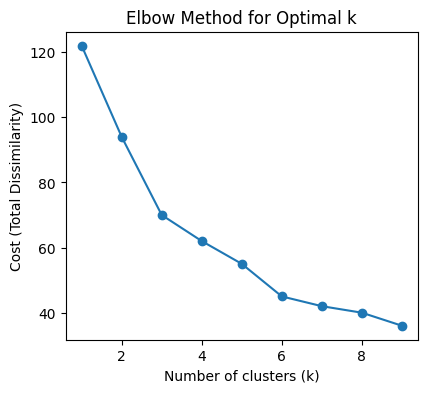

In [60]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ks, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost (Total Dissimilarity)')
plt.title('Elbow Method for Optimal k')

In [80]:
kmode = KModes(n_clusters=6, init='Huang', n_init=5, verbose=1,random_state=42)
kmode.fit(df_cluster)
mc['new_cluster'] = kmode.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7, cost: 49.0
Run 1, iteration: 2/100, moves: 7, cost: 45.0
Run 1, iteration: 3/100, moves: 2, cost: 45.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12, cost: 46.0
Run 2, iteration: 2/100, moves: 0, cost: 46.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8, cost: 61.0
Run 3, iteration: 2/100, moves: 0, cost: 61.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11, cost: 57.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 18, cost: 47.0
Run 5, iteration: 2/100, moves: 1, cost: 47.0
Best run was number 1


In [83]:
prog_clust = mc[mc['new_cluster'] == 3]['normalized_name'].tolist()